<a href="https://colab.research.google.com/github/fellowship/platform-demos3/blob/master/InriaAerialImages/Inria_Resized_512_resnet34_Cross_Entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inria Aerial Satellite Image Labelling

The main aim of this challenge is to be able to classify pixels as 'building' or 'not building'. This is a clear case of semantic segmentation. We have180 aerial images from various cities with a resolution of 5000 X 5000, along with the segmented masks of 5000 X 5000. Our goal is to classify each of the pixels in the test image and generate a masks for the test images too.

**Project Notebook created by : Pallavi Allada, Jhansi Anumula, Zoheb Abai**

In [1]:
# Fast.ai on collab
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
# Notebook magic commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Mounting Google drive to Colab for file access !

In [3]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Download Data 

Downloading the dataset images from the URL mentioned in the inria site using curl cmd. This command downloads the dataset as 7z parts and then unzips it under the folder AerialImageDataset.

In [0]:
# Do not execute every time !! Already downloaded datasets !
#!curl -k https://files.inria.fr/aerialimagelabeling/getAerial.sh | bash

## Preprocess the data
Resize the images to lower resolution (512) and copy to disk. The original images are 5kX5k, which is difficult to train, hence the resizing.

In [0]:
# Linking folders to respective path
from fastai.vision import *
src_path = Path('/content/AerialImageDataset/')
root_path = Path('/content/drive/My Drive/fellowship/Datasets/InriaDataset/')

image_hr_path = src_path/'train/images'
mask_hr_path = src_path/'train/gt'
test_hr_path = src_path/'test/images'

image_lr_path = root_path/'train'
test_lr_path = root_path/'test'
train_mask_lr_path = root_path/'masks'

hr_images = ImageList.from_folder(image_hr_path)
hr_masks = ImageList.from_folder(mask_hr_path)
hr_tests = ImageList.from_folder(test_hr_path)

In [6]:
# Define the function to resizing the images using Bilinear Interpolation
def resize_img(filename, i, lr_path, hr_path, size):
    dest = lr_path/filename.relative_to(hr_path)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(filename)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR)
    img.save(dest, quality=100)

# create smaller image sets using resizing
sets = [(image_lr_path, 512, hr_images, image_hr_path),(test_lr_path, 512, hr_tests, test_hr_path),(train_mask_lr_path, 512, hr_masks, mask_hr_path)]  
for lr_path,size,itm_list,hr_path in sets: 
    if not lr_path.exists(): 
        print(f"resizing to {size} into {lr_path}")
        parallel(partial(resize_img, lr_path=lr_path, hr_path=hr_path, size=size), itm_list.items)
        


resizing to 512 into /content/drive/My Drive/fellowship/Datasets/InriaDataset/train


resizing to 512 into /content/drive/My Drive/fellowship/Datasets/InriaDataset/test


resizing to 512 into /content/drive/My Drive/fellowship/Datasets/InriaDataset/masks


In [7]:
# Check if all images are resized
images = get_image_files(image_lr_path)
masks = get_image_files(train_mask_lr_path)
len(images),len(masks)

(180, 180)

## EDA

Import required fastai libraries

In [8]:
from fastai.vision import *
from fastai import *
import fastai
from fastai.callbacks.hooks import *
print(fastai.__version__)

1.0.52


Check the sample images  and their dimensions in train and test folders

In [9]:
root_dir = Path('/content/drive/My Drive/fellowship/Datasets/InriaDataset')
train_path = root_dir/'train'
test_path = root_dir/'test'
mask_path = root_dir/'masks'
img_path = train_path
img_path, mask_path

(PosixPath('/content/drive/My Drive/fellowship/Datasets/InriaDataset/train'),
 PosixPath('/content/drive/My Drive/fellowship/Datasets/InriaDataset/masks'))

In [10]:
# Check if all images are present in the folders 
images = get_image_files(img_path)
masks = get_image_files(mask_path)
len(images),len(masks)

(180, 180)

In [11]:
# Size of each image and its mask
image = open_image(images[0])
img_size = np.array(image.shape[1:])
print(image.shape)

mask = open_mask(masks[0], div=True)
print(mask.shape)
mask_size = np.array(mask.shape[1:])
print(mask.data)

np.unique(np.array(mask.data))

torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


array([0, 1])

Function to get the corresponding mask file (labels) of an image file (inputs)

In [12]:
get_mask_file = lambda x: mask_path/f'{x.stem.split("/")[-1]}.tif'
img = images[0]
img, get_mask_file(img)

(PosixPath('/content/drive/My Drive/fellowship/Datasets/InriaDataset/train/tyrol-w35.tif'),
 PosixPath('/content/drive/My Drive/fellowship/Datasets/InriaDataset/masks/tyrol-w35.tif'))

### Data Visualization 

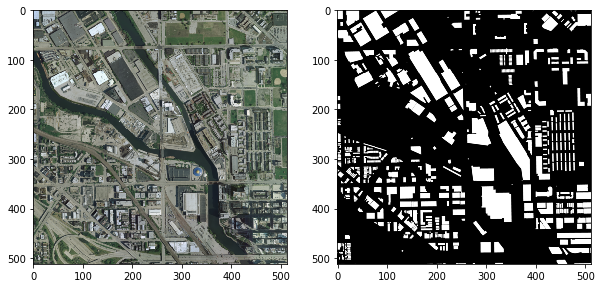

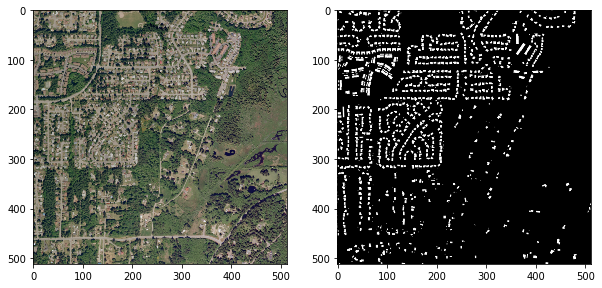

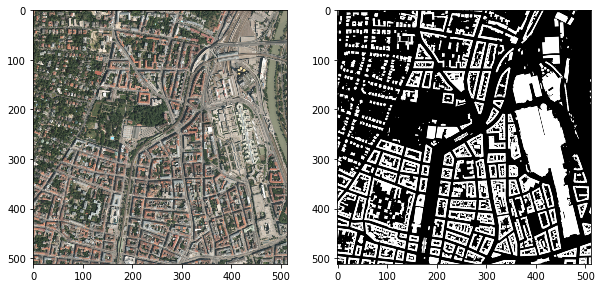

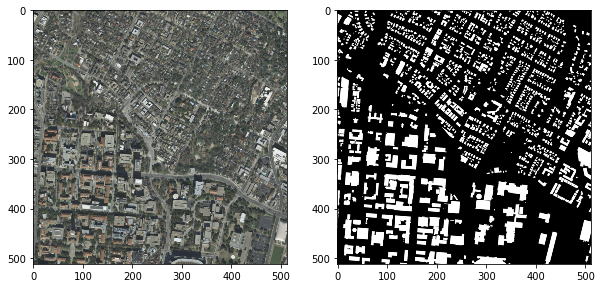

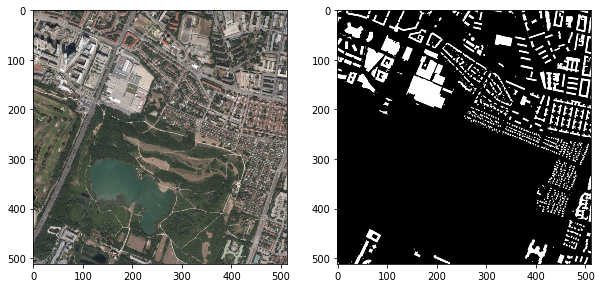

In [13]:
import matplotlib.pyplot as plt

# Display a sample of random images as their corresponding masks

def display_image_mask_grid(n):
  images_list = []
  for i in range(n):
    images_list.append(random.choice(os.listdir(img_path)))
  for idx, image in enumerate(images_list):  
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    img = plt.imread(str(img_path/image))
    axs[0].imshow(img)
    msk = plt.imread(str(mask_path/image))
    axs[1].imshow(msk, cmap='gray')    
    plt.grid(False)
    plt.show()  
    

display_image_mask_grid(5)

## U-Net Model

In [14]:
# Parameters
codes = np.array(['NotBuilding','Building'])
src_size = np.array(mask.shape[1:])
size = src_size
bs = 4
size, bs

(array([512, 512]), 4)

In [0]:
# Subclass the segmentation label list to get masked values within 0 and 1
class MaskSegmentationLabelList(SegmentationLabelList):
    def open(self, fn): 
      return open_mask(fn, div=True)

class MaskSegmentationItemList(ImageList):
    _label_cls,_square_show_res = MaskSegmentationLabelList, False
    

In [0]:
# Using datablock api generate the databunch for training and validation set
src = MaskSegmentationItemList.from_folder(train_path).split_by_fname_file(root_dir/'valid.txt').label_from_func(get_mask_file, classes=codes)
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
)


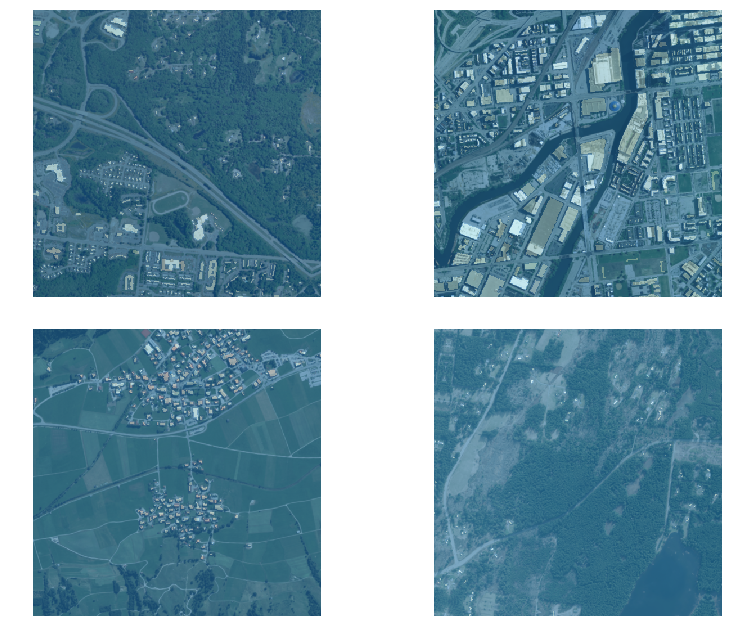

In [36]:
# Visualizing a batch from databunch

data.show_batch(rows=3, figsize=(12,9))

In [37]:
# Display data(x,y) in train and validation sets
len(data.train_ds.x.items), len(data.train_ds.y.items),len(data.valid_ds.x.items), len(data.valid_ds.y.items)

(155, 155, 25, 25)

In [38]:
# Labels
data.classes


array(['NotBuilding', 'Building'], dtype='<U11')

### Custom Loss 

In [0]:
def dice_loss(input, target):
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)

In [0]:
# Defining Metrics
#iou = partial(dice, iou=True)
metrics = [dice_loss, accuracy_thresh, dice]

In [0]:
# Defining the Model. Using pretrained resnet 34 model as encoder.
learn = unet_learner(data, models.resnet34, metrics=metrics)

In [0]:
# Define metrics to be displayed
learn.metrics = metrics

In [0]:
# Define loss function for the model 
learn.loss_func = combo_loss

##Training the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


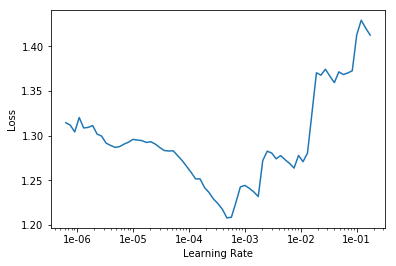

In [44]:
# Plot the Loss- Lr curve
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
# Choosing the learning rate
lr = 1e-04

In [46]:
# Training the cycle for 10 epochs
learn.fit_one_cycle(10, slice(lr))

In [47]:
# Further training the cycle for 10 epochs
learn.fit_one_cycle(10, slice(lr))

In [0]:
# Save the trained model
learn.save("stage-1-rn34-512")

In [0]:
# Load the trained model
learn = learn.load("stage-1-rn34-512")

## Finetuning the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


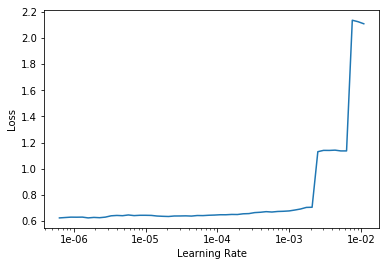

In [50]:
# Plot the Loss- Lr curve
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [51]:
# Training the cycle for 10 epochs
lr = 1e-04
learn.fit_one_cycle(10, slice(1e-6,lr))

In [52]:
# Further training the cycle for 10 epochs
learn.fit_one_cycle(10, max_lr=slice(1e-5,lr))

In [0]:
# Save the trained model
learn.save("stage-2-rn34-512-1")

In [0]:
# Load the trained model
learn = learn.load("stage-2-rn34-512-1")

In [55]:
# Training the cycle for 20 epochs
learn.fit_one_cycle(20, max_lr=slice(1e-5,lr))

In [56]:
# Further training the cycle for 10 epochs
learn.fit_one_cycle(10, max_lr=slice(1e-5,lr))

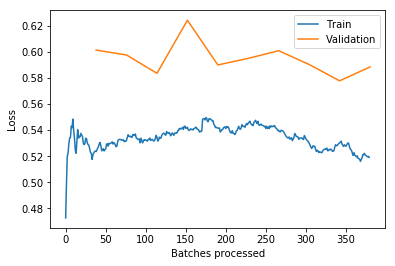

In [57]:
learn.recorder.plot_losses()

**The losses seem to have stabilised, so evaluating the model on test dataset**

In [0]:
# Save the trained model
learn.save("stage-2-rn34-512-2")

In [0]:
# Load the trained model
learn = learn.load("stage-2-rn34-512-2")

In [60]:
# Predicting on Validation dataset
outputs = learn.pred_batch(ds_type=DatasetType.Valid)
outputs.shape

torch.Size([4, 2, 512, 512])

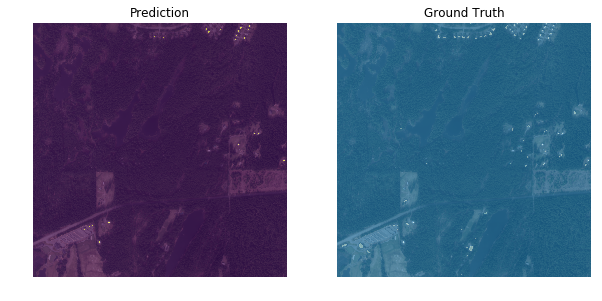

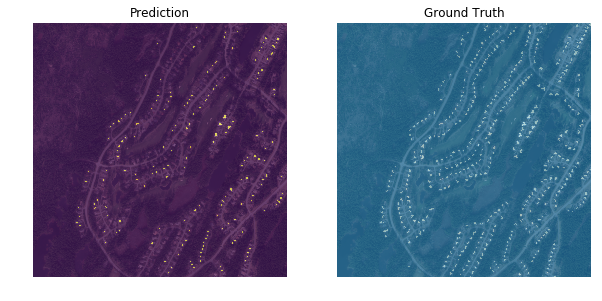

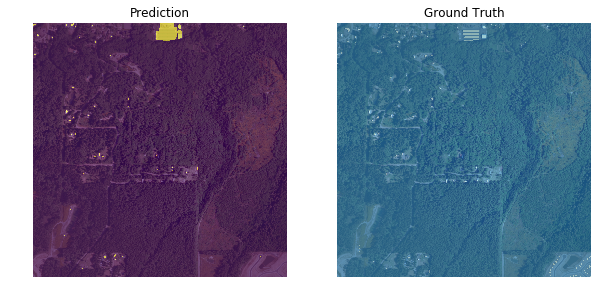

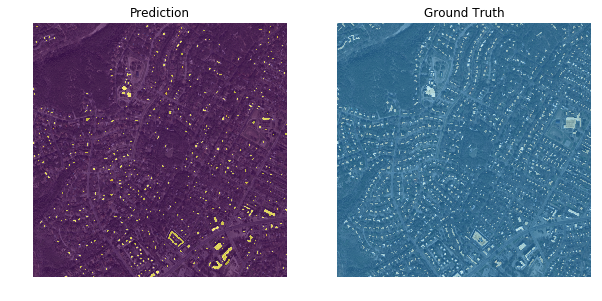

In [62]:
# Comparing Model's prection and ground truth values
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1].sigmoid()>0.70)), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

**Predicting Single Test image on our model**

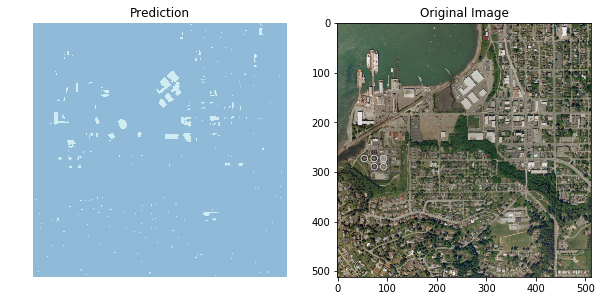

In [69]:
img = open_image(test_path/'bellingham2.tif')
prediction = learn.predict(img)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_title('Prediction')
prediction[0].show(figsize=(5,5), ax=ax1)
ax2.set_title('Original Image')
img = plt.imread(str(test_path/'bellingham2.tif'))
ax2.imshow(img)

**Our model got max accuracy of 95% but IOU value of 0.5, which did not cross the baseline model of INRIA mentioned [here](https://project.inria.fr/aerialimagelabeling/leaderboard/). We need to proceed with a different image preprocessing approach, of slicing the image into sliding window patches to generate a 256 X 256 or 512x 512 tile/patch from all the training data and mask data.**